# Imports, pip e variáveis globais

In [1]:
# Maneira elegante de instalar os pacotes para que não demore nas execuções seguintes
if 'package_installed_kv_pair' not in globals():
    # Se não estiver definida, inicializa como um dicionário vazio
    package_installed_kv_pair = {}

# Lista de pacotes a serem verificados/instalados
packages = ['qiskit-aer', 'qiskit', 'qiskit-ibm-runtime', 'qiskit_aer', 'pylatexenc', 'tweedledum', 'qiskit-algorithms']

# Verifica se cada pacote já está instalado
for package in packages:
    if package_installed_kv_pair.get(package) is None:
        package_installed_kv_pair[package] = True
        !pip install {package}

In [5]:
# Visualization
from qiskit.visualization import array_to_latex
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# BackEnd
from qiskit.providers.basic_provider import BasicProvider

# Circuit
from qiskit import QuantumRegister, QuantumCircuit, transpile, assemble
from qiskit.circuit.library import CCZGate, ZGate
from qiskit.circuit.library import Diagonal
from qiskit.circuit.library import PhaseOracle

# Utils
from qiskit.quantum_info import Statevector
import numpy as np
import pandas as pd
import itertools
import statistics


In [6]:
# Global
CLAUSES_QTY = 3 # 4-SAT
QUBIT_QTY = CLAUSES_QTY

EXPRESSION_3SAT = "(~A | ~B | ~C) & (A | ~B | C) & (A | B | ~C) & (A | ~B | ~C) & (~A | B | C)"
EXPRESSION_4SAT =  "(~A | B | C | D) & (A | ~B | C | D) & (A | B | ~C | D) & (A | B | C | ~D) & (A | B | ~C | ~D)"

EXPRESSIONS = {
    3 : EXPRESSION_3SAT,
    4 : EXPRESSION_4SAT
}
EXPRESSION = EXPRESSIONS[CLAUSES_QTY]

# EXPERIMENTAL
USE_RANDOM_EXPRESSION = False

# Utilidade

In [7]:
# Função não otimizada, porém simples para gerar expressões k-sat
import random
def GenerateSatExpression(k):
  alfabeto = [chr(letra) for letra in range(ord('A'), ord('Z')+1)]
  if (k > len(alfabeto)):
    print("No momento, ainda não é possível gerar")
  expr = ""
  for i in range(k):
    expr += "("
    for j in range(k):
      if (random.choice([True, False])):
        expr += "~"
      expr += f"{alfabeto[j]}"
      if j != k-1:
        expr += " | "
    expr += ")"
    if (i != k-1):
      expr += " & "
  return expr
if (USE_RANDOM_EXPRESSION is True):
  CLAUSES_QTY = 3
  QUBIT_QTY = CLAUSES_QTY
  random_expr = GenerateSatExpression(CLAUSES_QTY)
  EXPRESSION = random_expr
  print(EXPRESSION)

# Criação do Oráculo que representa a nossa expressão

In [8]:
def GetOracle():
  print(f"Using expression: {EXPRESSION}")
  oracle = PhaseOracle(EXPRESSION)
  return oracle

Using expression: (A | B | C) & (A | B | C) & (A | B | C) & (A | B | C) & (A | B | C)


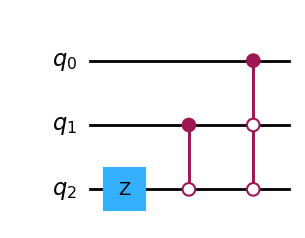

In [12]:
EXPRESSION = "(A | B | C) & (A | B | C) & (A | B | C) & (A | B | C) & (A | B | C)"

oracle = GetOracle()
oracle.draw("mpl")

# Zero Reflection
Parecido com a implementação do qiskit APENAS para 3-SAT

(não utilizamos aqui)
def GetZeroReflection(oracle):
  num_qubits = QUBIT_QTY
  qubits = [0, 1, 2]
  qr_state = QuantumRegister(num_qubits, "state")
  reflection = QuantumCircuit(qr_state)

  first_qubit = qubits[0]
  second_qubit = qubits[1]
  third_qubit = qubits[2]

  reflection.x(qubits)
  reflection.h(qubits[third_qubit])
  reflection.mcx([0,1], qubits[third_qubit])
  reflection.h(qubits[third_qubit])
  reflection.x(qubits)

  return reflection


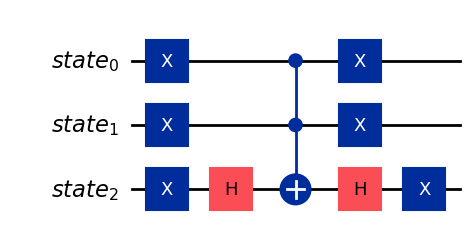

In [ ]:
zeroReflection = GetZeroReflection(oracle)
zeroReflection.draw("mpl")

# Diagonal
Baseado na implementação de Giancarlo
* https://github.com/giangamberi/
Estudo-de-algoritmos-quanticos-e-suas-implementacoes/blob/main/EAQSI.ipynb

* https://dspace.mackenzie.br/items/071a8df2-1a8f-45c2-ab22-49749d06479b

In [ ]:
def convertDiagonal(number, qubits):
    diagonalSize = pow(2,qubits)
    if (diagonalSize < number - 1): return -1
    aux = np.ones(diagonalSize, dtype=int) # Criacao um array do tamanho da qtd de 2 qubits
    aux[number] = -1
    return aux

def GetDiagonal(oracle):
  # Montagem da diagonal
  qubit_qtd = QUBIT_QTY
  allQbits = [i for i in range(qubit_qtd)]

  groverDiagonal = list(convertDiagonal(0, qubit_qtd))
  return Diagonal(groverDiagonal)

In [ ]:
diagonal = GetDiagonal(oracle)
diagonal.decompose().draw()

global phase: π/8
     ┌─────────────────┐                               
q_0: ┤0                ├───────────────────────────────
     │                 │┌───────────────┐              
q_1: ┤1 Ucrz(-π,0,0,0) ├┤0              ├──────────────
     │                 ││  Ucrz(-π/2,0) │┌────────────┐
q_2: ┤2                ├┤1              ├┤ Ucrz(-π/4) ├
     └─────────────────┘└───────────────┘└────────────┘

# Concatenando oráculo com operador de grover
(Grover Operator + Oracle)

In [ ]:
def ApplyGrover(oracle):
  num_qubits = QUBIT_QTY
  qr = QuantumRegister(num_qubits, name="State")
  qc = QuantumCircuit(qr, name = "Grover Operator")
  qubits = list(range(QUBIT_QTY)) # Maneira automatizada de fazer [0,1,2]
  qc.compose(oracle, qubits, inplace=True)

  # Aplica Hadamart Para cada qubit
  for q in range(num_qubits):
    qc.h(q)
  #Aplica a diagonal
  qc.compose(
      GetDiagonal(oracle),qubits, inplace=True
  )
  # Aplica Hadamart Para cada qubit
  for q in range(num_qubits):
    qc.h(q)
  return qc

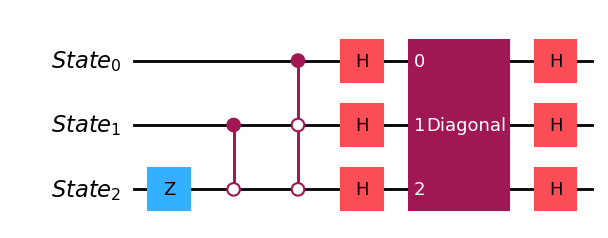

In [ ]:
oracle = GetOracle()
merged_two = ApplyGrover(oracle)
merged_two.draw("mpl")

# Amplificação com hadamart
(Hadamart > Grover Operator)

In [ ]:
def AmplifyWithHadamart(qc, oracle):
  for i in range(QUBIT_QTY):
    qc.h(i)

  qc.compose(oracle, inplace=True)
  return qc

# Montagem do circuito

Hadamart -> Grover and Oracle -> Measure

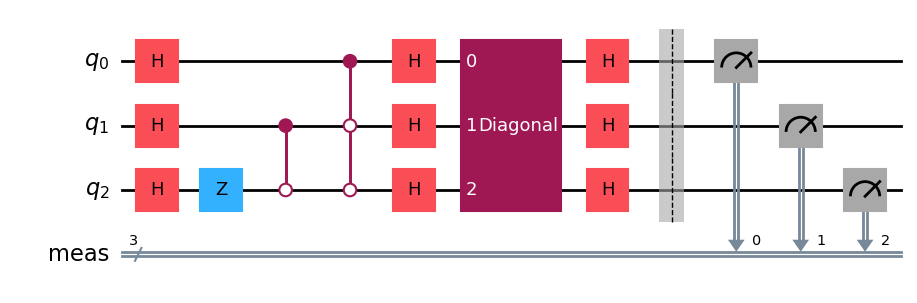

In [ ]:
# Using Our Grover Operator
sat_problem = QuantumCircuit(QUBIT_QTY, name=f"Circuit for our {CLAUSES_QTY}-sat problem")

oracle = GetOracle()
groverCircuit = ApplyGrover(oracle)
AmplifyWithHadamart(sat_problem, groverCircuit)

sat_problem.measure_all()
sat_problem.draw("mpl")

In [ ]:
# Aqui podemos imprimir o vetor de estados facilmente
def PrintStateVector(qc: QuantumCircuit) -> Statevector:
    qc.remove_final_measurements()
    statevector = Statevector(qc)
    sat_problem.measure_all()
    return array_to_latex(statevector, prefix="\\text{Vetor de Estados} = ")
PrintStateVector(sat_problem)

<IPython.core.display.Latex object>

# Montagem do circuito usando o Qiskit para criar o oráculo (para fins de comparação)

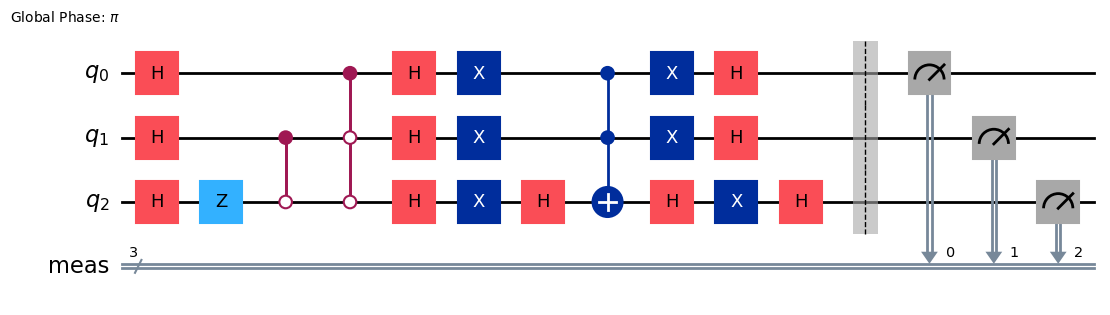

In [ ]:
#Using IBM Grover
from qiskit.circuit.library import GroverOperator

sat_problem_using_ibm = QuantumCircuit(QUBIT_QTY, name=f"Circuit for our {CLAUSES_QTY}-sat problem")
oracle = GetOracle()
groverCircuit = GroverOperator(oracle).decompose()
AmplifyWithHadamart(sat_problem_using_ibm, groverCircuit)
sat_problem_using_ibm.measure_all()
sat_problem_using_ibm.draw("mpl")

# Execução do circuito

In [ ]:
backend = BasicProvider().get_backend("basic_simulator")

# Execução do circuito - Nosso
transpiled = transpile(sat_problem, backend)
qobj = assemble(transpiled)
result = backend.run(transpiled).result()
count = result.get_counts()

# Execução do circuito - IBM - GROVER
transpiled = transpile(sat_problem_using_ibm, backend)
qobj = assemble(transpiled)
resultIBM = backend.run(transpiled).result()
countIBM = resultIBM.get_counts()

# Apresentação dos resultados obtidos

{'000': 813, '001': 42, '101': 25, '011': 30, '111': 31, '100': 30, '010': 22, '110': 31}


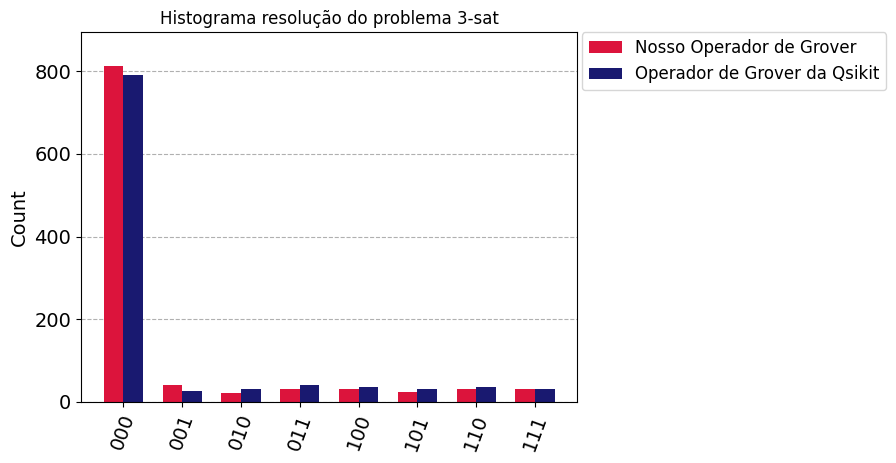

In [ ]:
# Plot
fig, ax = plt.subplots()
legend = ["Nosso Operador de Grover", "Operador de Grover da Qsikit"]
title = f"Histograma resolução do problema {CLAUSES_QTY}-sat"
plot_histogram([count, countIBM], color=['crimson','midnightblue'], title=title, legend=legend, bar_labels=False, ax=ax)

print(count)
plt.show()

# Comparação e Implementação brute force

In [ ]:
def generate_truth_table(expression):
    variables = sorted(set([char for char in expression if char.isalpha()]))
    expression = expression.replace("~", " not ")
    expression = expression.replace("&", " and ")
    expression = expression.replace("|", " or ")
    rows = []
    for combination in itertools.product([False, True], repeat=len(variables)):
        variables_dict = {}
        for i in range(len(variables)):
          variables_dict[variables[i]] = combination[i]
        result = eval(expression, variables_dict)
        row_values = list(combination) + [result]
        rows.append(row_values)

    columns = variables + [expression]
    truth_table = pd.DataFrame(rows, columns=columns)
    truth_table = truth_table.rename(columns={truth_table.columns[-1]: 'Result'})
    return truth_table

# Exemplo de uso:
brute_force_truth_table = generate_truth_table(EXPRESSION)
print(brute_force_truth_table)

       A      B      C  Result
0  False  False  False   False
1  False  False   True    True
2  False   True  False    True
3  False   True   True    True
4   True  False  False    True
5   True  False   True    True
6   True   True  False    True
7   True   True   True    True


In [ ]:
# Conversão de cada linha para uma lista de strings
def GetRowValuesAsList(df):
  string_list = []
  for index, row in df.iterrows():  # Excluindo a última linha
      string_values = ['1' if value else '0' for value in row[:-1]]  # Convertendo valores booleanos em strings 'True' ou 'False'
      string_list.append(''.join(string_values))  # Unindo os valores em uma única string e adicionando à lista
  string_list.sort()
  return string_list

# Captura dos dados que resultam em true || false no data frame obtido
def GetBruteForceResults(df):
  sat_brute_force = (brute_force_truth_table[brute_force_truth_table['Result'] == True])
  unsat_brute_force = (brute_force_truth_table[brute_force_truth_table['Result'] == False])

  sat_brute_force = GetRowValuesAsList(sat_brute_force)
  unsat_brute_force = GetRowValuesAsList(unsat_brute_force)
  return { "SAT" : sat_brute_force , "UNSAT" : unsat_brute_force}

brute_force_results = GetBruteForceResults(generate_truth_table(EXPRESSION))
print("SOLUÇÃO BRUTE FORCE: ", brute_force_results,)

SOLUÇÃO BRUTE FORCE:  {'SAT': ['001', '010', '011', '100', '101', '110', '111'], 'UNSAT': ['000']}


In [ ]:
# Resultado do nosso circuito
def GetResults():
  median = statistics.mean([value for _, value in count.items()])
  results_sat = [key for key, value in count.items() if value >= median]
  results_unsat =  [key for key, _ in count.items() if key not in results_sat]

  results_sat = [key[::-1] for key in results_sat]
  results_unsat = [key[::-1] for key in results_unsat]

  results_sat.sort()
  results_unsat.sort()
  return { "SAT" : results_sat , "UNSAT" : results_unsat}

results = GetResults()
print("NOSSA SOLUÇÃO: ", results)

NOSSA SOLUÇÃO:  {'SAT': ['000'], 'UNSAT': ['001', '010', '011', '100', '101', '110', '111']}


In [ ]:
brute_force_results = GetBruteForceResults(generate_truth_table(EXPRESSION))
print("FORÇA BRUTA: \t", brute_force_results)

shouldIterate = False
results = GetResults()
print("NOSSA SOLUÇÃO: \t", results)
if (results["SAT"] == brute_force_results["UNSAT"]):
    print("Resultados obtidos de satisfação são iguais aos obtidos de NÃO SATISFAÇÃO em força bruta")
elif (results["SAT"] == brute_force_results["SAT"]):
    print("Resultados obtidos de satisfação são iguais aos obtidos em força bruta")
else:
  print("Nenhum resultado bate com apenas uma iteração")
  shouldIterate = True

FORÇA BRUTA: 	 {'SAT': ['001', '010', '011', '100', '101', '110', '111'], 'UNSAT': ['000']}
NOSSA SOLUÇÃO: 	 {'SAT': ['000'], 'UNSAT': ['001', '010', '011', '100', '101', '110', '111']}
Resultados obtidos de satisfação são iguais aos obtidos de NÃO SATISFAÇÃO em força bruta


# Testes com iteração




In [ ]:
# Execução do circuito - 1000 iteracoes
num_iterations = 1000
def Iterate():
  brute_force_results = GetBruteForceResults(generate_truth_table(EXPRESSION))
  for i in range(num_iterations):
    sat_problem_using_ibm = QuantumCircuit(QUBIT_QTY, name=f"Circuit for our {CLAUSES_QTY}-sat problem")
    oracle = GetOracle()
    groverCircuit = GroverOperator(oracle).decompose()
    AmplifyWithHadamart(sat_problem_using_ibm, groverCircuit)
    sat_problem_using_ibm.measure_all()
    transpiled = transpile(sat_problem, backend)
    qobj = assemble(transpiled)
    result = backend.run(transpiled).result()
    count = result.get_counts()

    results = GetResults()
    if (results["SAT"] == brute_force_results["UNSAT"]):
      print("Resultados obtidos de satisfação são iguais aos obtidos de NÃO SATISFAÇÃO em força bruta")
      break
    elif (results["SAT"] == brute_force_results["SAT"]):
      print("Resultados obtidos de satisfação são iguais aos obtidos em força bruta")
      break
    if i == num_iterations-1:
      print(f"Nenhum resultado bate mesmo iterando {num_iterations} vezes")

In [ ]:
if (shouldIterate):
  Iterate()